# PCA con Bedrock

### Preparación

In [1]:
# Librerías utilizadas

import boto3 #AWS Command Line Interface
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
# Crear cliente para comunicarse con Bedrock, utilizando métodos y funciones para invocar los modelos y obtener embeddings

bedrock_runtime = boto3.client(
    service_name='bedrock-runtime',
    region_name='us-east-1', 
)

In [3]:
# Función para obtener el embedding de cada categoría

def add_embedding(descripcion, modelo):
    """
    Obtiene el embedding de un texto utilizando un modelo de Amazon Bedrock.

    Args:
        descripcion (string): Texto para obtener el embedding.
        modelo (string): ID del modelo de Amazon Bedrock que se utiliza.

    Returns:
        list: Lista de números que representan el embedding del texto.
    """
    
    prompt_data = descripcion
    body = json.dumps({"inputText": prompt_data,})
    
    # Invocar el modelo 
    response = bedrock_runtime.invoke_model(
        body = body, 
        modelId = modelo, 
        accept = 'application/json', 
        contentType = 'application/json')
    
    # De la respuesta a la invocación, se lee el contenido de la respuesta
    response_body = json.loads(response['body'].read())
    
    # Se obtiene el valor del embedding
    embedding = response_body.get('embedding')
    
    # Retorna el embedding
    return embedding

In [4]:
# Función para obtener la categoría de una solicitud

def categoria_modelo(solicitud, modelo, vector):
    """
    Selecciona la categoría más relevante para una solicitud utilizando un modelo dado, calculando la similitud
    del coseno entre el embedding de la pregunta y los embeddings de las categorías.

    Args:
        solicitud (string): Texto para obtener el embedding.
        modelo (string): ID del modelo de Amazon Bedrock que se utiliza.
        vector (lista): Lista de embeddings de las categorías calculados con "modelo".

    Returns:
        string: Nombre de la categoría que tiene la mayor similitud con la solicitud.
    """
    
    # Obtiene el embedding de la pregunta
    query_embedding = add_embedding(solicitud, modelo)
    
    # Calcula la similitud del coseno
    cosine_scores = cosine_similarity([query_embedding], vector)[0]
    
    # Serie con la similitud para cada categoría
    score_series = pd.Series(cosine_scores, index = df_cat['Categoría'])
    
    # Serie con las similitudes en orden descendente
    sorted_scores = score_series.sort_values(ascending=False)
    
    return(sorted_scores.index[0])

### Obtener categoría y descripción

In [5]:
# Dataframe con las categorías

df_cat = pd.read_csv(r"categorias10.txt", sep=';')
df_cat

,Categoría,Descripción
0,Información,El cliente busca obtener información detallada...
1,Negociación,El cliente desea negociar los términos de pago...
2,Reclamo,El cliente presenta un reclamo o disputa forma...
3,Reestructuración,El cliente solicita un plan de pago estructura...
4,Actualización,El cliente necesita actualizar su información ...
5,Amenaza,"El cliente utiliza un lenguaje abusivo, amenaz..."
6,Documentación,El cliente solicita copias de documentos respa...
7,Cierre,El cliente solicita el cierre definitivo de su...
8,Prórroga,El cliente solicita una prórroga o aplazamient...
9,Otros,Esta categoría abarca cualquier otro tipo de l...


In [6]:
# Crear lista con los nombres de las categorías

categorias = list(df_cat['Categoría'])
categorias

['Información',
 'Negociación',
 'Reclamo',
 'Reestructuración',
 'Actualización',
 'Amenaza',
 'Documentación',
 'Cierre',
 'Prórroga',
 'Otros']

In [7]:
# Crear lista con las descripciones de las categorías

descripcion = list(df_cat['Descripción'])
descripcion

['El cliente busca obtener información detallada sobre su deuda, incluyendo montos, fechas, cargos adicionales y cualquier otra información relevante relacionada con su situación de cobranza.',
 'El cliente desea negociar los términos de pago, como montos, plazos, intereses o posibles quitas, con el objetivo de llegar a un acuerdo más favorable para su situación financiera.',
 'El cliente presenta un reclamo o disputa formal, argumentando que la deuda es errónea, los cargos son injustificados o el proceso de cobranza ha sido inadecuado o abusivo.',
 'El cliente solicita un plan de pago estructurado, donde se establezcan cuotas fijas y fechas específicas para realizar los pagos, con el fin de saldar la deuda de manera organizada.',
 'El cliente necesita actualizar su información personal, como dirección, números de contacto, situación laboral o fuentes de ingresos, con el objetivo de facilitar el proceso de cobranza.',
 'El cliente utiliza un lenguaje abusivo, amenazante o intimidante, 

### Obtener embeddings

#### 1. Amazon Titan Text Embedding v1

In [8]:
# Identificador del modelo en Bedrock
model_id_v1 = "amazon.titan-embed-g1-text-02"

# Lista para guardar los embeddings generados con Amazon Titan Text Embedding v1
lista_embeddings_mod_v1 = []

#### 2. Amazon Titan Text Embedding v2

In [9]:
# Identificador del modelo en Bedrock
model_id_v2 = "amazon.titan-embed-text-v2:0"

# Lista para guardar los embeddings generados con Amazon Titan Text Embedding v2
lista_embeddings_mod_v2 = []

#### 3. Calcular embeddings

In [10]:
# Recorre la lista con las descripciones de las categorías
# Calcula el embedding con model_id_v1 y lo almacena en lista_embeddings_mod_v1
# Luego, calcula el embedding con model_id_v2 y lo almacena en lista_embeddings_mod_v2

for i in range(len(descripcion)):
    emb_v1 = add_embedding(descripcion[i], model_id_v1)
    lista_embeddings_mod_v1.append(emb_v1)    
    emb_v2 = add_embedding(descripcion[i], model_id_v2)
    lista_embeddings_mod_v2.append(emb_v2)

In [11]:
# Verificando que todas las listas tengan el mismo largo

len(lista_embeddings_mod_v1), len(lista_embeddings_mod_v2), len(categorias), len(descripcion)

(10, 10, 10, 10)

In [12]:
# Agrega la columna embedding_v1 con los embeddings generados con model_id_v1
# y la columna embedding_v2 con los embeddings generados con model_id_v2

df_cat['embedding_v1'] = lista_embeddings_mod_v1
df_cat['embedding_v2'] = lista_embeddings_mod_v2
df_cat

,Categoría,Descripción,embedding_v1,embedding_v2
0,Información,El cliente busca obtener información detallada...,"[0.27539062, 0.0039978027, 0.24609375, 0.39648...","[-0.08915264, -0.022460938, -0.017364033, 0.00..."
1,Negociación,El cliente desea negociar los términos de pago...,"[0.1953125, 0.1953125, 0.57421875, -0.03466797...","[-0.109322034, -0.01082907, 0.026642948, -0.00..."
2,Reclamo,El cliente presenta un reclamo o disputa forma...,"[-0.09033203, -0.13769531, 0.26171875, 0.14648...","[-0.07116127, -0.012416159, 0.02390574, -0.012..."
3,Reestructuración,El cliente solicita un plan de pago estructura...,"[0.1875, 0.007751465, 0.6171875, 0.203125, 0.1...","[-0.084964335, 0.037744947, 0.058680404, -0.01..."
4,Actualización,El cliente necesita actualizar su información ...,"[0.24511719, 0.09277344, 0.2578125, 0.12890625...","[-0.059150256, -0.021074492, -0.038075764, -0...."
5,Amenaza,"El cliente utiliza un lenguaje abusivo, amenaz...","[0.4140625, 0.32421875, 0.3359375, -0.08007812...","[-0.017301137, 0.10290415, 0.04453162, -0.0127..."
6,Documentación,El cliente solicita copias de documentos respa...,"[0.56640625, -0.10253906, 0.2421875, 0.1591796...","[-0.03509922, -0.03855727, 0.0052303025, -0.02..."
7,Cierre,El cliente solicita el cierre definitivo de su...,"[0.546875, -0.08154297, 0.43554688, 0.07275390...","[-0.05492514, 0.01058613, 0.0058683986, -0.006..."
8,Prórroga,El cliente solicita una prórroga o aplazamient...,"[-0.026489258, 0.23339844, 0.42382812, -0.1513...","[-0.07856215, -0.031059453, -0.019640537, -0.0..."
9,Otros,Esta categoría abarca cualquier otro tipo de l...,"[0.095214844, 0.19042969, 0.59375, -0.12890625...","[-0.021136105, 0.044860303, -0.015701106, 0.00..."


### PCA

#### 1. Amazon Titan Text Embedding v1

In [13]:
# Reducción de dimensionalidad con PCA

pca = PCA(n_components=2)
pca_result_v1 = pca.fit_transform(lista_embeddings_mod_v1)

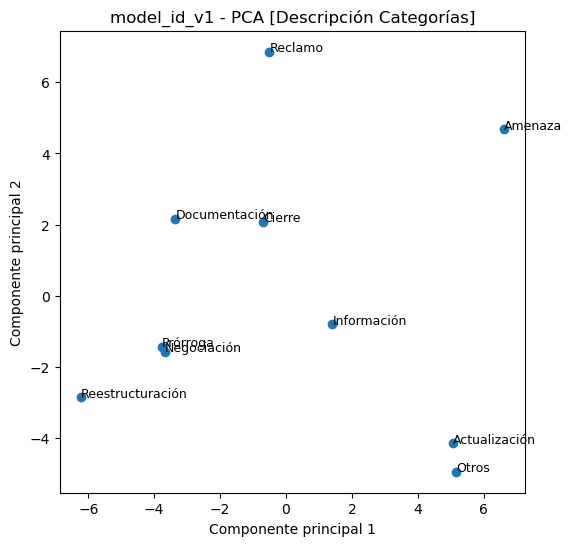

In [14]:
plt.figure(figsize=(6,6))
plt.scatter(pca_result_v1[:, 0], pca_result_v1[:, 1])

for i, tabla in enumerate(categorias):
    plt.text(pca_result_v1[i, 0], pca_result_v1[i, 1], tabla, fontsize=9)

plt.title('model_id_v1 - PCA [Descripción Categorías]')
plt.xlabel('Componente principal 1')
plt.ylabel('Componente principal 2')
plt.show()

#### 2. Amazon Titan Text Embedding v2

In [15]:
# Reducción de dimensionalidad con PCA
pca_v2 = PCA(n_components=2)
pca_result_v2 = pca_v2.fit_transform(lista_embeddings_mod_v2)

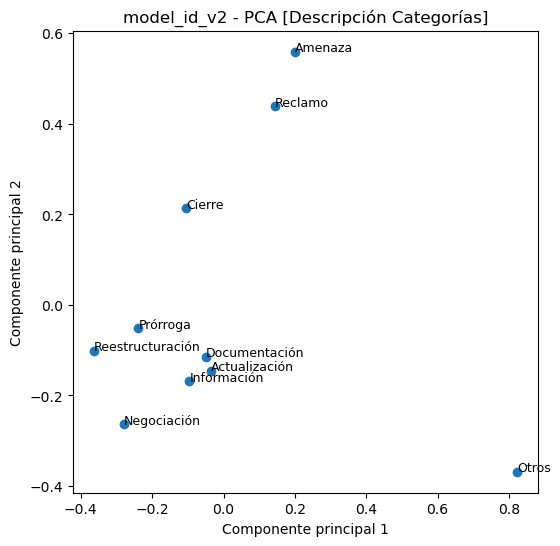

In [16]:
plt.figure(figsize=(6, 6))
plt.scatter(pca_result_v2[:, 0], pca_result_v2[:, 1])

for i, tabla in enumerate(categorias):
    plt.text(pca_result_v2[i, 0], pca_result_v2[i, 1], tabla, fontsize=9)

plt.title('model_id_v2 - PCA [Descripción Categorías]')
plt.xlabel('Componente principal 1')
plt.ylabel('Componente principal 2')
plt.show()

### Evaluación

In [17]:
# Se crea un set de pruebas con la categoría a la que pertenecen las solicitudes

evaluacion = [
["necesito saber el saldo de mi deuda", "Información"],
["Si no pago, me van a cortar el servicio?", "Infomación"],
["Necesito información sobre los requisitos", "Información"],
["puedo pagar el 10 en vez del 5?", "Prórroga"],
["pagaré el 10 en vez del 5", "Prórroga"],
["necesito pagar el 10", "Prórroga"],
["Necesito una prórroga para el pago", "Prórroga"],
["Me gustaría extender el plazo de pago", "Prórroga"],
["Necesito un plan de pago a plazos", "Información"],
["Quisiera negociar un nuevo acuerdo de pago", "Negociación"],
["Necesito reestructurar mi deuda", "Reestructuración"],
["Necesito un plan de pagos porque tengo muchas deudas", "Reestructuración"],
["Llamo para informar que hice el pago total", "Cierre"],
["Quiero cerrar mi cuenta por completo", "Cierre"],
["Quiero cerrar mi cuenta", "Cierre"],
["te odio tonto", "Amenaza"],
["tengo un reclamo, yo nunca firme esta deuda", "Reclamo"],
["Me cambié de casa", "Actualización"],
["Falta adjuntar un documento que respalde mi deuda", "Documentación"],
["Qué hora es?", "Otros"]
]
print(len(evaluacion))

20


#### 1. Amazon Titan Text Embedding v1

In [18]:
# Evalúa el desempeño de model_id_v1

print("Las solicitudes que no logra clasificar correctamente son:\n")
aciertos = 0
for i in range(len(evaluacion)):
    resultado = categoria_modelo(evaluacion[i][0], model_id_v1, lista_embeddings_mod_v1)
    if evaluacion[i][1] == resultado:
        aciertos = aciertos + 1
    else:
        print(f"{i+1}. {evaluacion[i][0]} (es {evaluacion[i][1]}). Clasificación modelo: {resultado}.")
        

Las solicitudes que no logra clasificar correctamente son:

2. Si no pago, me van a cortar el servicio? (es Infomación). Clasificación modelo: Cierre.
3. Necesito información sobre los requisitos (es Información). Clasificación modelo: Otros.
5. pagaré el 10 en vez del 5 (es Prórroga). Clasificación modelo: Negociación.
6. necesito pagar el 10 (es Prórroga). Clasificación modelo: Negociación.
8. Me gustaría extender el plazo de pago (es Prórroga). Clasificación modelo: Negociación.
9. Necesito un plan de pago a plazos (es Información). Clasificación modelo: Reestructuración.
11. Necesito reestructurar mi deuda (es Reestructuración). Clasificación modelo: Cierre.
13. Llamo para informar que hice el pago total (es Cierre). Clasificación modelo: Negociación.
18. Me cambié de casa (es Actualización). Clasificación modelo: Cierre.


In [19]:
print(f"El modelo {model_id_v1} clasificó correctamente {aciertos} de {len(evaluacion)} solicitudes")

El modelo amazon.titan-embed-g1-text-02 clasificó correctamente 11 de 20 solicitudes


#### 2. Amazon Titan Text Embedding v2

In [20]:
# Evalúa el desempeño de model_id_v2

print("Las solicitudes que no logra clasificar correctamente son:\n")
aciertos = 0
for i in range(len(evaluacion)):
    resultado = categoria_modelo(evaluacion[i][0], model_id_v2, lista_embeddings_mod_v2)
    if evaluacion[i][1] == resultado:
        aciertos = aciertos + 1
    else:
        print(f"{i+1}. {evaluacion[i][0]} (es {evaluacion[i][1]}). Clasificación modelo: {resultado}.")

Las solicitudes que no logra clasificar correctamente son:

2. Si no pago, me van a cortar el servicio? (es Infomación). Clasificación modelo: Cierre.
9. Necesito un plan de pago a plazos (es Información). Clasificación modelo: Reestructuración.


In [21]:
print(f"El modelo {model_id_v2} clasificó correctamente {aciertos} de {len(evaluacion)} solicitudes")

El modelo amazon.titan-embed-text-v2:0 clasificó correctamente 18 de 20 solicitudes


### Conclusión

El modelo que mejor identifica la categoría de la solicitud de un usuario es Amazon Titan Text Embedding v2, ya que logra identificar correctamente la mayor cantidad de categorías correctas.

Se observa que el modelo Amazon Titan Text Embedding v1 tiene dificultad para identificar las categorías "Prórroga" y "Negociación", lo que podría explicarse por la cercanía y casi superposición de ambas categorías en el gráfico de PCA.

Ambos modelos tienen dificultad en ciertos casos de "Información" que identifican como "Cierre". Se recomienda profundizar en la descripción de estas categorías para que las solicitudes puedan ser correctamente clasificadas.

Consideraciones:
- El set de evaluación debe contener diversos ejemplos para cada categoría.
- Es posible que el set de evaluación tenga algún error humano, como se puede intuir en: "9. Necesito un plan de pago a plazos (es Información). Clasificación modelo: Reestructuración.". En este caso, se podría sugerir una revisión detallada del motivo de la clasificación, ya que según la descripción de la categoría, podría corresponder a Reestructuración.
- Tanto los datos de evaluación como las categorías y sus descripciones pueden ir variando en el tiempo de acuerdo a las necesidades del negocio.